In [1]:
import pandas as pd
import matplotlib.pyplot as pl
import numpy as np
from matplotlib.patches import Patch
import pickle
from sklearn.metrics import r2_score

from timeit import default_timer as timer

from IMU_JAE.vicon_methods import window_ml_data

# TF machine learning imports
from keras import Sequential, optimizers
from keras.layers import Dense, Conv1D, Conv2D, Flatten, LSTM
from keras.regularizers import l1 as L1, l2 as L2

%matplotlib notebook

Using TensorFlow backend.


In [2]:
file = open('ml_raw.pickle', 'rb')
[a1, w1, wd1, a2, w2, wd2, c1, c2, cs1, cs2, subjs, locs, events] = pickle.load(file)
file.close()

In [5]:
# data
dc = np.concatenate((np.concatenate((a1, a2), axis=1).reshape((-1, 6, 1)), np.concatenate((w1, w2), axis=1).reshape((-1, 6, 1)), 
                     np.concatenate((wd1, wd2), axis=1).reshape((-1, 6, 1))), axis=2)
tc = np.concatenate((cs1[:, 0].reshape((-1, 1)), cs2[:, 0].reshape((-1, 1))), axis=1)

N = 128  # number of samples per "image"
data = []
target = []
cnn_subs = []
for sub in subjs.unique():
    si = subjs == sub
#     for ev in events.unique():
#         ei = events == ev
    for loc in locs.unique():
        li = locs == loc
        ind = si & li  # mask for subject, event, and location
        dcs = dc[ind]
        tcs = tc[ind]

        n = np.sum(ind)  # number of samples

        if n//N == 0:
            continue
        images = np.zeros((n//N, 128, 6, 3))
        jcs = np.zeros((n//N, 2))
        for i in range(n//N):
            images[i] = dcs[i*N:i*N+N]
            jcs[i] = np.median(tcs[i*N:i*N+N], axis=0)
            cnn_subs.append(sub)
        data.append(images)
        target.append(jcs)

data = np.concatenate(tuple(data[i] for i in range(len(data))), axis=0)
target = np.concatenate(tuple(target[i] for i in range(len(target))), axis=0)

In [6]:
def run_ml(data, target, subjs, model, plot='6', verbose=1, epochs=15, batch_size=128, validation_split=0, model_weights='cnn_weights.h5'):
    pl.close('all')
    sc = []
    r2 = []
    figs = []
    model_hist = []
    for sub in np.unique(subjs):
        model.load_weights(model_weights)
        trn = subjs != sub  # TRaining Index
        tst = subjs == sub  # TEsting Index
        
        start = timer()
        hist = model.fit(data[trn], target[trn], verbose=verbose, epochs=epochs, batch_size=batch_size, validation_split=validation_split)
        train_time = timer() - start
        
        model_hist.append(hist)
        
        sc.append(model.evaluate(data[tst], target[tst], verbose=verbose)[1])

        pred = model.predict(data[tst])

        r2.append(r2_score(target[tst], pred))
        
        print(f'Subject: {sub}  Score: {sc[-1]:.4f}   Variance Score: {r2[-1]:.4f}  Time: {train_time:.2f}s')
        
        if plot == '6':
            f, ax = pl.subplots(nrows=2, ncols=3, figsize=(12, 8))
            f.suptitle(f'Subject: {sub}  Score: {sc[-1]:.4f}   Variance Score: {r2[-1]:.4f}  Time: {train_time:.2f}s')
            for i in range(3):
                ax[0, i].plot(target[tst, i], label='Target')
                ax[0, i].plot(pred[:, i], '.', label='Prediction', alpha=0.25)
                ax[0, i].set_title('Sensor 1')
                ax[0, i].set_xlabel('Sample')
                ax[0, i].legend()
            for i in range(3):
                ax[1, i].plot(target[tst, i + 3], label='Target')
                ax[1, i].plot(pred[:, i + 3], '.', label='Prediction', alpha=0.25)
                ax[1, i].set_title('Sensor 2')
                ax[1, i].set_xlabel('Sample')
                ax[1, i].legend()
            for i in range(2):
                ax[i, 0].set_ylabel('Position [m]')
                ax[i, 1].set_ylabel('Angle [rad]')
                ax[i, 2].set_ylabel('Angle [rad]')
        elif plot == '2':
            f, ax = pl.subplots(2, figsize=(9, 5))
            f.suptitle(f'Subject: {sub}  Score: {sc[-1]:.4f}   Variance Score: {r2[-1]:.4f}  Time: {train_time:.2f}s')
            for i in range(2):
                ax[i].plot(target[tst, i], label='Target')
                ax[i].plot(pred[:, i], '.', label='Prediction', alpha=0.3)
                ax[i].set_title(f'Sensor {i+1}')
                ax[i].set_ylabel('Position [m]')
                ax[i].set_xlabel('Sample')
                ax[i].legend()
        elif plot is None:
            pass
        if plot is not None:
            f.tight_layout(rect=[0, 0.03, 1, 0.95])
            figs.append(f)
        
    return sc, r2, figs, model_hist

In [34]:
model = Sequential()
model.add(Conv2D(kernel_size=(32, 1), strides=1, filters=3, input_shape=(128, 6, 3), activation='tanh', use_bias=False, data_format='channels_last'))
model.add(Conv2D(kernel_size=(16, 1), strides=1, filters=2, activation='tanh', use_bias=False, data_format='channels_last'))
# model.add(Conv2D(kernel_size=(8, 1), strides=1, filters=6, activation='tanh', use_bias=False, data_format='channels_last'))
model.add(Flatten(data_format='channels_last'))
model.add(Dense(256, activation='tanh'))
model.add(Dense(128, activation='tanh'))
model.add(Dense(64, activation='tanh'))
model.add(Dense(2))

model.compile(optimizer='adam', loss='mse', metrics=['mse'])
model.save_weights('cnn_weights.h5')

In [37]:
print(f'{np.mean(r2):.4f}    {np.median(r2):.4f}')

-4.6791    -1.9245


Subject: S0001  Score: 0.0130   Variance Score: -1.7277  Time: 7.15s
Subject: S0002  Score: 0.0082   Variance Score: -1.9245  Time: 6.58s
Subject: S0004  Score: 0.0074   Variance Score: -3.2002  Time: 6.35s
Subject: S0005  Score: 0.0079   Variance Score: -1.7865  Time: 6.29s
Subject: S0006  Score: 0.0058   Variance Score: -0.5269  Time: 6.35s
Subject: S0007  Score: 0.0079   Variance Score: -3.2221  Time: 6.35s
Subject: S0008  Score: 0.0071   Variance Score: -20.3654  Time: 6.84s


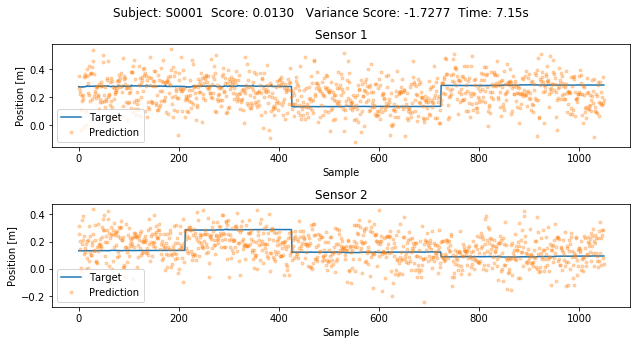

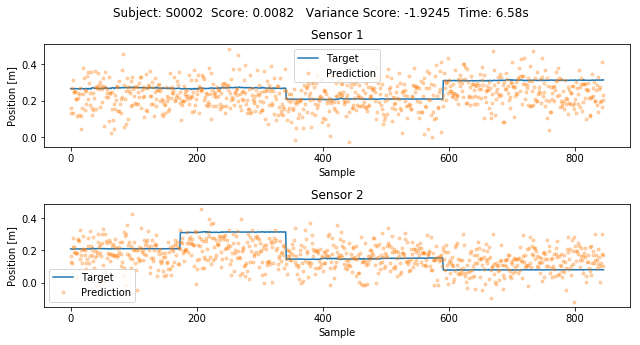

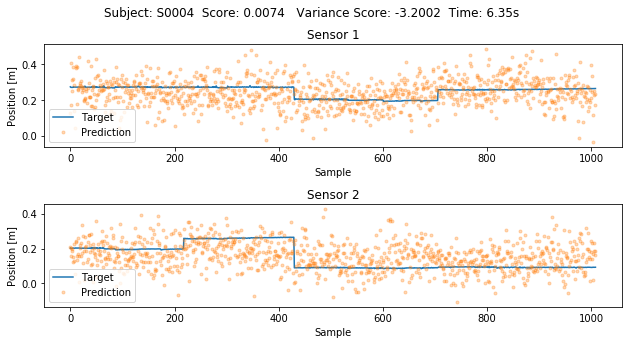

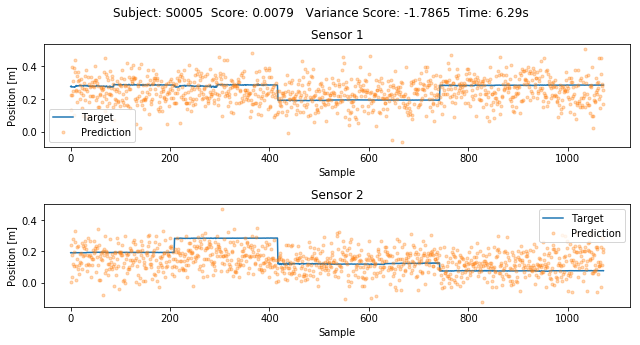

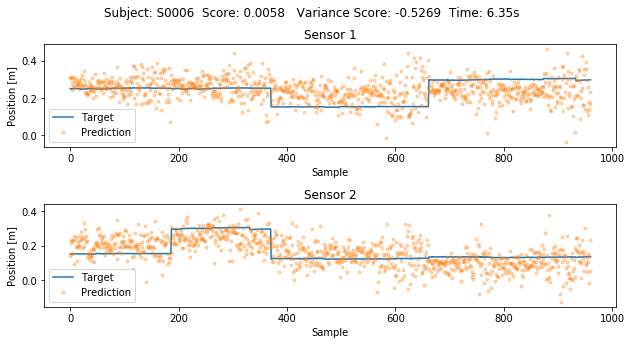

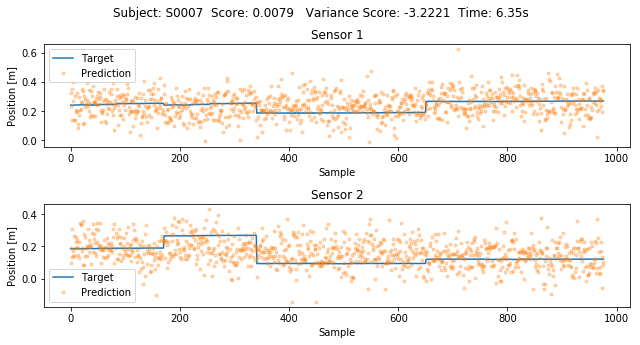

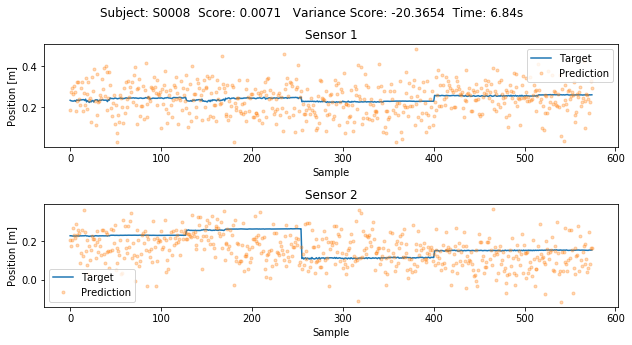

In [36]:
sc, r2, figs, mhist = run_ml(data, target, np.array(cnn_subs), model, plot='2', verbose=0, epochs=25, batch_size=256, validation_split=0, model_weights='cnn_weights.h5')

In [55]:
# 0-1, 1-2, 2-4, 3-5, 4-6, 5-7, 6-8
for i, s in enumerate([1, 2, 4, 5, 6, 7, 8]):
    figs[i].savefig(f'/home/lukas/Dropbox/Masters/Class - Machine Learning/Project/Images/CNN Images/CNN_32*3t-32*6t_256r-128r-64r_S000{s}.png', bbox_to_inches='tight', transparent=True)

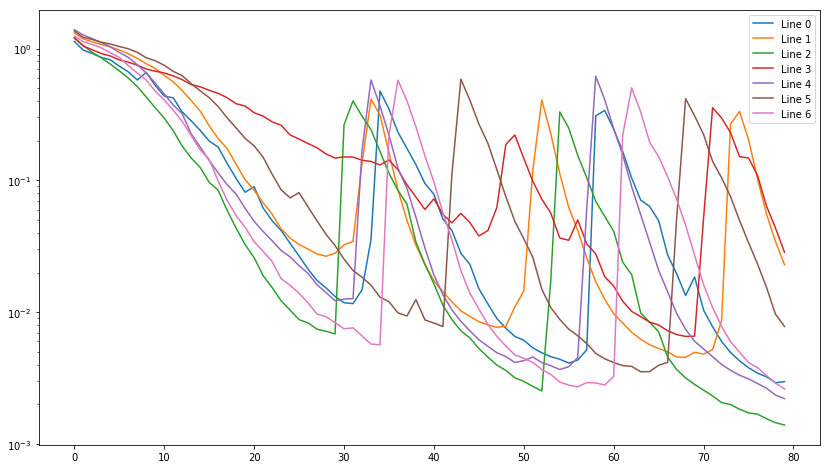

In [30]:
pl.figure(figsize=(14, 8))
for i, mh in enumerate(mhist):
    pl.semilogy(mh.history['mean_squared_error'], label=f'Line {i}')
pl.legend()

In [2]:
import tensorflow as tf
tf.test.is_gpu_available()

False

In [9]:
dc = np.concatenate((a1, a2, w1, w2, wd1, wd2), axis=1)
tc = np.concatenate((cs1[:, 0].reshape((-1, 1)), cs2[:, 0].reshape((-1, 1))), axis=1)

In [11]:
N = 128  # number of samples per "image"
data = []
target = []
cnn_subs = []
for sub in subjs.unique():
    si = subjs == sub
#     for ev in events.unique():
#         ei = events == ev
    for loc in locs.unique():
        li = locs == loc
        ind = si & li  # mask for subject, event, and location
        dcs = dc[ind]
        tcs = tc[ind]

        n = np.sum(ind)  # number of samples

        if n//N == 0:
            continue
        images = np.zeros((n//N, 128, 18))
        jcs = np.zeros((n//N, 2))
        for i in range(n//N):
            images[i] = dcs[i*N:i*N+N]
            jcs[i] = np.median(tcs[i*N:i*N+N], axis=0)
            cnn_subs.append(sub)
        data.append(images)
        target.append(jcs)

data = np.concatenate(tuple(data[i] for i in range(len(data))), axis=0)
target = np.concatenate(tuple(target[i] for i in range(len(target))), axis=0)

In [40]:
model = Sequential()
model.add(Conv1D(kernel_size=(32, ), strides=1, filters=64, input_shape=(128, 18), activation='tanh', use_bias=False, data_format='channels_last'))
model.add(Conv1D(kernel_size=(16, ), strides=1, filters=32, activation='tanh', use_bias=False, data_format='channels_last'))
# model.add(Conv1D(kernel_size=(8, ), strides=1, filters=6, activation='tanh', use_bias=False, data_format='channels_last'))
model.add(Flatten(data_format='channels_last'))
model.add(Dense(256, activation='tanh'))
model.add(Dense(128, activation='tanh'))
model.add(Dense(128, activation='tanh'))
model.add(Dense(2))

model.compile(optimizer='adam', loss='mse', metrics=['mse'])
model.save_weights('cnn_weights.h5')

In [41]:
print(np.mean(r2), np.median(r2))

-0.5186546796027146 0.007396716678752802


Subject: S0001  Score: 0.0056   Variance Score: -0.1771  Time: 6.89s
Subject: S0002  Score: 0.0018   Variance Score: 0.4997  Time: 5.92s
Subject: S0004  Score: 0.0092   Variance Score: -4.5602  Time: 5.70s
Subject: S0005  Score: 0.0010   Variance Score: 0.6839  Time: 5.67s
Subject: S0006  Score: 0.0088   Variance Score: -1.2748  Time: 5.76s
Subject: S0007  Score: 0.0042   Variance Score: -1.3601  Time: 5.79s
Subject: S0008  Score: 0.0049   Variance Score: -20.0008  Time: 6.19s


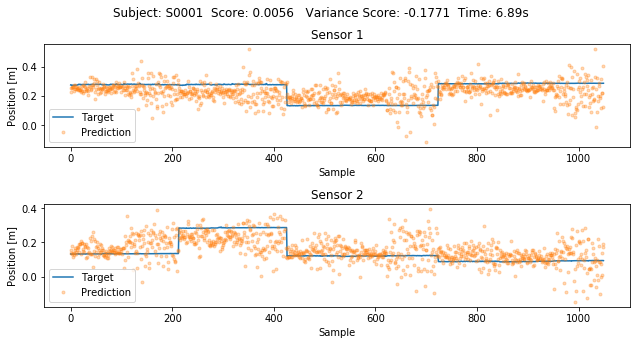

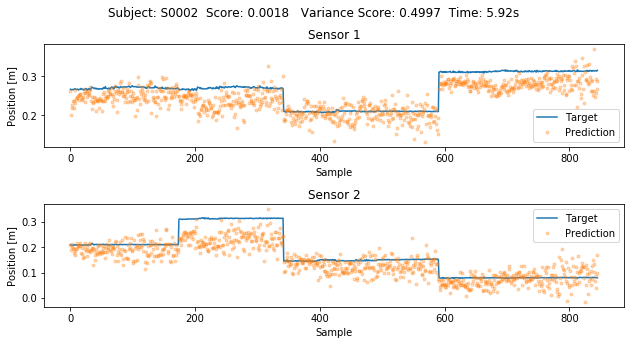

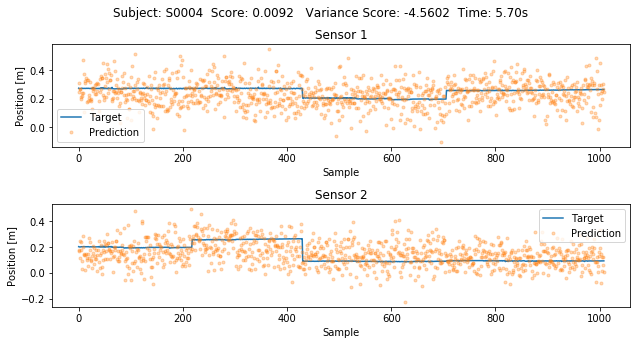

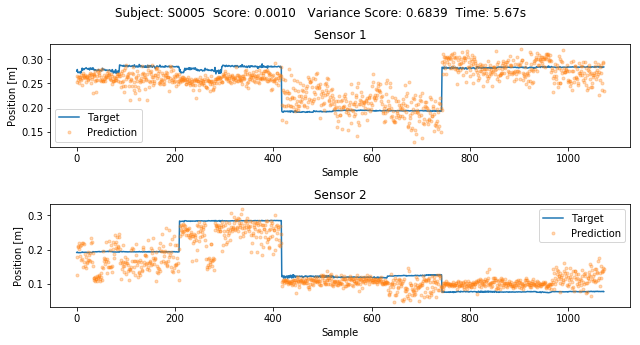

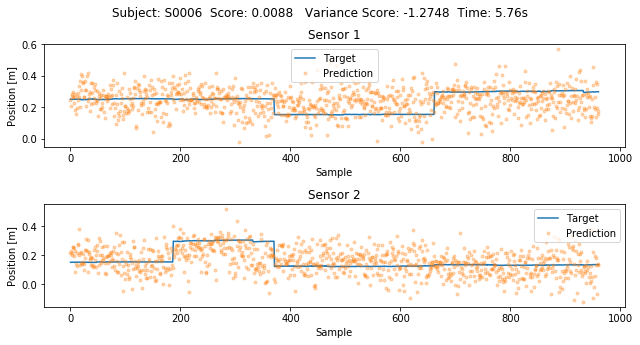

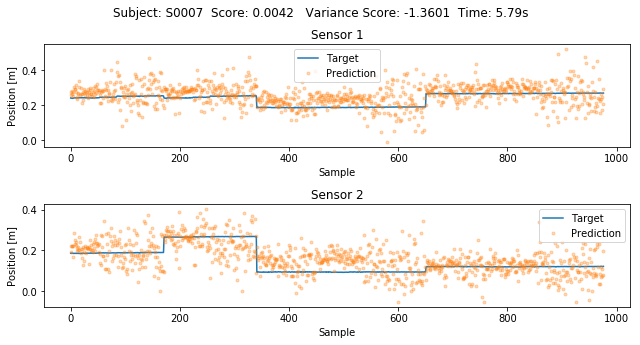

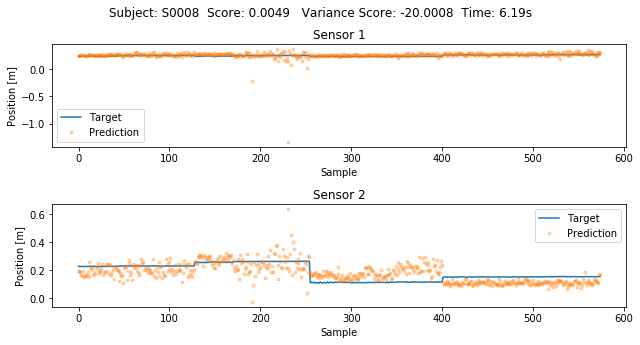

In [42]:
sc, r2, figs, mhist = run_ml(data, target, np.array(cnn_subs), model, plot='2', verbose=0, epochs=10, batch_size=128, validation_split=0, model_weights='cnn_weights.h5')

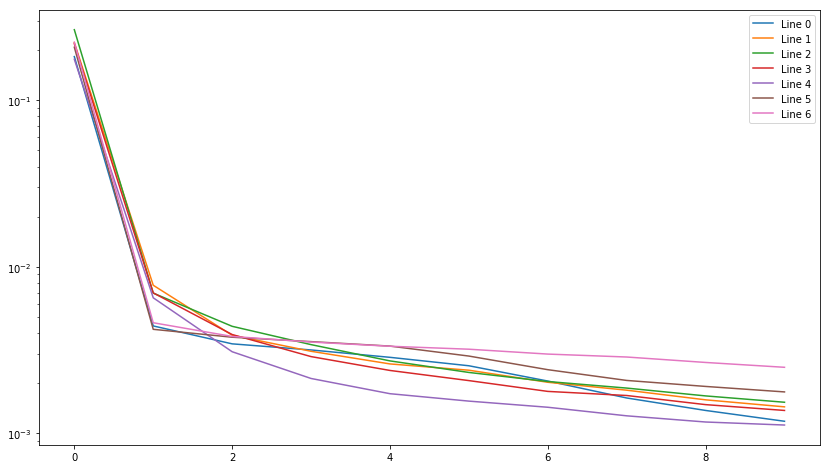

In [16]:
pl.figure(figsize=(14, 8))
for i, mh in enumerate(mhist):
    pl.semilogy(mh.history['mean_squared_error'], label=f'Line {i}')
pl.legend()